## NER based Resume parser and summarizer

### Installing the packages

In [1]:
# !python -m spacy info
# !pip install fitz
# !pip install PyMuPDF
# !pip install wordcloud
# !pip install ntlk
# !pip install PyMuPDF==1.16.14

### Importing the packages

In [1]:
import spacy
import pickle
import random
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from nltk.stem import PorterStemmer
nlp_spacy = spacy.load('en_core_web_sm')
stpwords = stopwords.words('english')
import sys,fitz

### Loading the Data

In [2]:
train_data = pickle.load(open('train_data.pkl', 'rb'))

### Training the model

In [ ]:
nlp = spacy.blank('en')

def train_model(train_data):
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True)
        
    for _, annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2])
            
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(10):
            print('Starting iteration ' + str(itn))
            random.shuffle(train_data)
            losses = {}
            index = 0
            for text, annotations in train_data:
                try:
                    nlp.update(
                        [text],
                        [annotations],
                        drop=0.2,
                        sgd = optimizer,
                        losses = losses)
                except Exception as e:
                    pass
            print(losses)

In [ ]:
train_model(train_data)

In [ ]:
nlp.to_disk('nlp_model')

### Loading the train model

In [3]:
nlp_model = spacy.load('nlp_model')

### PDF to text convert function

In [4]:
def pdf2text(input_resume):
    doc = fitz.open(input_resume)
    text = ""
    for page in doc:
        text = text+ str(page.getText())
    tx = " ".join(text.split('\n'))
    return tx

### Comparing Skills and skill score function

In [5]:
def candidateMatching(required_skills,updated_tokens_list):
    list_skills = required_skills.lower().split(",")
    found_skills_each_resume = []
    score = 0
    for x in list_skills:
        if x in updated_tokens_list:
            score += 1
            found_skills_each_resume.append(x)
    req_skills_len = len(list_skills)
    match = round(score / req_skills_len * 100, 1)
    
    return found_skills_each_resume,match

### Porter stemmer function for stemming 

In [6]:
def stemming_tokenizer(tokens_list):
    rootWord = []
    tokens = [x.lower() for xs in tokens_list for x in xs.split(',')]
    ps = PorterStemmer()
    for w in tokens_list:
        if w not in stpwords:
            rootWord.append(ps.stem(w))
    return rootWord

### Lemmatization function

In [7]:
def lemma_tokenizer(tokens_list):
    rootWord = []
    for token in tokens_list:
        if token.lemma_ not in stpwords:
            rootWord.append(token.lemma_)
    return [x.lower() for xs in rootWord for x in xs.split(',')]

### Entity extraction function

In [8]:
def entity_extraction(resume, required_skills):
    test=pdf2text(resume)
    doc = nlp_model(test)
    l=[]
    s=[]
    x={}
    for ent in doc.ents:
        if ent.label_.upper() not in l:
            l.append(ent.label_.upper())
            print(f'{ent.label_.upper():{30}}- {ent.text}')
            x[ent.label_.upper()]=ent.text
        text_list=[test]
        tokens_list=' '.join(text_list).split()
        
#     updated_tokens_list= [x.lower() for xs in tokens_list for x in xs.split(',')]
#     updated_tokens_list= stemming_tokenizer(tokens_list)
    updated_tokens_list=lemma_tokenizer(doc)
    final_token_list.extend(updated_tokens_list)
    x['Skills'],x['Match']=candidateMatching(required_skills,updated_tokens_list)
    extractedDetails[i]=x

In [9]:
extractedDetails={} 
final_token_list=[]
found_skills = {}

### Adding resume documents path

In [10]:
import os
path = "E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes"
  
os.chdir(path)
file_path=[]
for file in os.listdir():
    file_path.append(f"{path}\{file}")
print(file_path)

['E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes\\Alice Clark CV.pdf', 'E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes\\ara.pdf', 'E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes\\dd.pdf', 'E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes\\Hash.pdf', 'E:/Book 3/SEMESTER 5/CSE4022 - NATURAL LANGUAGE PROCESSING/J COMP/resumes\\Narendra.pdf']


### Defining requirement skills and cutoff

In [12]:
skill_set='engineering,python,NLP,API,HTML,express'
cutoff = 25.0

### Calling the netity extraction function 

In [13]:
for i in range(len(file_path)):
    entity_extraction(file_path[i],skill_set)

NAME                          - Alice Clark
LOCATION                      - Delhi
DESIGNATION                   - Software Engineer
COMPANIES WORKED AT           - Microsoft
DEGREE                        - Indian Institute of Technology – Mumbai
NAME                          - B ARAVINDA
DEGREE                        - B. Tech Student I'm currently pursuing, B. Tech in Computer Science at VIT. Interested in the ﬁeld of Computer Science and Technologies. Enthusiastic Learner in the ﬁeld of Data Science, Web and App Development. aravinda992@gmail.com +919840280874 Chennai
NAME                          - Divya shree
DESIGNATION                   - Score B.Tech
NAME                          - Hashwanth S
DESIGNATION                   - +91-8248336430 | hashwanth2002@gmail.com | https://www.linkedin.com/in/stykerhash/ |
DEGREE                        - Institute of Technology
NAME                          - Narendra G
COLLEGE NAME                  - Vellore Institute of Technology, Chennai


### Extracted entities

In [14]:
extractedDetails

{0: {'NAME': 'Alice Clark',
  'LOCATION': 'Delhi',
  'DESIGNATION': 'Software Engineer',
  'COMPANIES WORKED AT': 'Microsoft',
  'DEGREE': 'Indian Institute of Technology – Mumbai',
  'Skills': [],
  'Match': 0.0},
 1: {'NAME': 'B ARAVINDA',
  'DEGREE': "B. Tech Student I'm currently pursuing, B. Tech in Computer Science at VIT. Interested in the ﬁeld of Computer Science and Technologies. Enthusiastic Learner in the ﬁeld of Data Science, Web and App Development. aravinda992@gmail.com +919840280874 Chennai",
  'Skills': ['engineering', 'python', 'html'],
  'Match': 50.0},
 2: {'NAME': 'Divya shree',
  'DESIGNATION': 'Score B.Tech',
  'Skills': ['python', 'html'],
  'Match': 33.3},
 3: {'NAME': 'Hashwanth S',
  'DESIGNATION': '+91-8248336430 | hashwanth2002@gmail.com | https://www.linkedin.com/in/stykerhash/ |',
  'DEGREE': 'Institute of Technology',
  'Skills': ['engineering', 'python', 'api', 'html', 'express'],
  'Match': 83.3},
 4: {'NAME': 'Narendra G',
  'COLLEGE NAME': 'Vellore In

#### Inference

### Cutoff checker and ranking

In [15]:
def cutoff_checker(extractedDetails, cutoff):
    for i in range(len(extractedDetails)):
        name = extractedDetails.get(i, {}).get('NAME')
        match = extractedDetails.get(i, {}).get('Match')
        if match>=cutoff:
            ranking[name]=match

In [16]:
ranking = {}
cutoff_checker(extractedDetails, cutoff)

In [17]:
ranking

{'B ARAVINDA': 50.0,
 'Divya shree': 33.3,
 'Hashwanth S': 83.3,
 'Narendra G': 50.0}

### Final shortlisted resume and score

In [18]:
for i in ranking:
    print(i,'-',ranking.get(i))

B ARAVINDA - 50.0
Divya shree - 33.3
Hashwanth S - 83.3
Narendra G - 50.0


## Visualization and evaluation

In [27]:
String = ' '.join([str(elem) for elem in final_token_list])

### word cloud for tokens

In [29]:
def plot_wordcloud(text,max_words=400, max_font_size=120, figure_size=(6.0,4.0), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    stopwords = stpwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

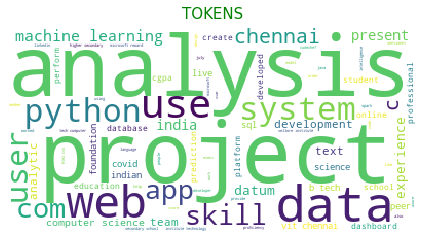

In [30]:
common_text = String
plot_wordcloud(common_text,max_words=80, max_font_size=100, 
               title = 'TOKENS', title_size=15)

### visualizing the resume ranking

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.DataFrame(list(ranking.items()))
df.columns = ['Candidates', 'skill score']
df

,Candidates,skill score
0,B ARAVINDA,50.0
1,Divya shree,33.3
2,Hashwanth S,83.3
3,Narendra G,50.0


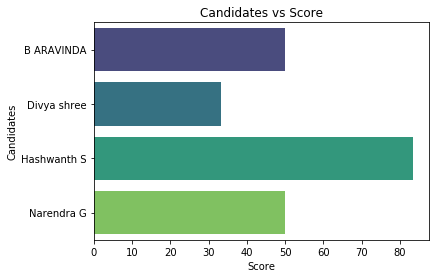

In [37]:
ax = sns.barplot('skill score','Candidates',data = df, palette="viridis")
ax.set(xlabel='Score', ylabel='Candidates')
plt.title("Candidates vs Score")
plt.show()

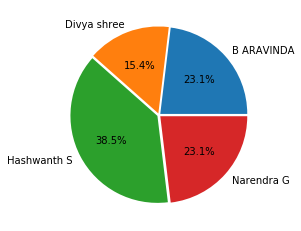

In [40]:
plt.pie(df['skill score'],labels=df['Candidates'],autopct="%.1f%%",explode=[0.02]*len(df))
plt.show()

### Model performance

In [19]:
mapper = {}
max_entity = 0
for i in range(len(extractedDetails)):
    entity = len(extractedDetails[i])-1
    if entity > max_entity:
        max_entity = entity
    mapper[extractedDetails[i]['NAME']] = entity

In [22]:
Entities_df = pd.DataFrame(list(mapper.items()))
Entities_df.columns = ['Candidates', 'Entities Found']
Entities_df

,Candidates,Entities Found
0,Alice Clark,6
1,B ARAVINDA,3
2,Divya shree,3
3,Hashwanth S,4
4,Narendra G,3


In [23]:
print("Max entities found : ",max_entity)

Max entities found :  6


In [26]:
import math
Avg_entities = sum(Entities_df['Entities Found'])/len(df)
math.floor(Avg_entities) 

4

#### The model was able to find maximum 6 entities and an average of 4 entities per resume

### Summarizer and skills dataframe

In [27]:
summarized = {}
for i in range(len(extractedDetails)):
    each_resume = []
    for j in extractedDetails[i]:
        if j!='Match':
            each_resume.append(extractedDetails[i][j])
    summarized[extractedDetails[i]['NAME']] = each_resume
summarized

{'Alice Clark': ['Alice Clark',
  'Delhi',
  'Software Engineer',
  'Microsoft',
  'Indian Institute of Technology – Mumbai',
  []],
 'B ARAVINDA': ['B ARAVINDA',
  "B. Tech Student I'm currently pursuing, B. Tech in Computer Science at VIT. Interested in the ﬁeld of Computer Science and Technologies. Enthusiastic Learner in the ﬁeld of Data Science, Web and App Development. aravinda992@gmail.com +919840280874 Chennai",
  ['engineering', 'python', 'html']],
 'Divya shree': ['Divya shree', 'Score B.Tech', ['python', 'html']],
 'Hashwanth S': ['Hashwanth S',
  '+91-8248336430 | hashwanth2002@gmail.com | https://www.linkedin.com/in/stykerhash/ |',
  'Institute of Technology',
  ['engineering', 'python', 'api', 'html', 'express']],
 'Narendra G': ['Narendra G',
  'Vellore Institute of Technology, Chennai',
  ['engineering', 'python', 'html']]}

### Dataframe of candidates and their skills matched with requirement

In [28]:
candidate_skills = {}
for i in summarized:
    skills = summarized[i][-1]
    if skills != []:
        candidate_skills[i] = ",".join(summarized[i][-1])
    else:
        candidate_skills[i] = 'None'
candidate_skills = pd.DataFrame(list(candidate_skills.items()))
candidate_skills.columns = ['Candidates', 'Matched Skills']
candidate_skills

,Candidates,Matched Skills
0,Alice Clark,None
1,B ARAVINDA,"engineering,python,html"
2,Divya shree,"python,html"
3,Hashwanth S,"engineering,python,api,html,express"
4,Narendra G,"engineering,python,html"


### Summarized resume of input candidate

In [29]:
candidate_name = input()
length = len(summarized[candidate_name])
candidate_details = []
for i in range(length):
    candidate_details.append(summarized[candidate_name][i])
for text in candidate_details:
    print(text, end=',')

B ARAVINDA
B ARAVINDA,B. Tech Student I'm currently pursuing, B. Tech in Computer Science at VIT. Interested in the ﬁeld of Computer Science and Technologies. Enthusiastic Learner in the ﬁeld of Data Science, Web and App Development. aravinda992@gmail.com +919840280874 Chennai,['engineering', 'python', 'html'],